Time series analysis and weekly sales forecast using Random forest regressor and Auto-ARIMA machine learning models.

In [149]:
import pandas as pd
import os

# Use the current directory
directory = '.'

# List all CSV files in the current directory
csv_files = [f for f in os.listdir(directory) if f.endswith('.csv')]

# Read each CSV file and append it to a list of DataFrames
dataframes = [pd.read_csv(file) for file in csv_files]

# Concatenate all DataFrames in the list into a single DataFrame
dataset = pd.concat(dataframes, ignore_index=True)

# Display the first few rows of the combined DataFrame
df = dataset.copy()

df.head()


,Store,Date,Dept,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size,week,month,year,day
0,1,2010-02-05,1,24924.50,0,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.09636,8.106,1,151315,5,2,2010,5
1,1,2010-02-12,1,46039.49,1,38.51,2.548,0.0,0.0,0.0,0.0,0.0,211.24217,8.106,1,151315,6,2,2010,12
2,1,2010-02-19,1,41595.55,0,39.93,2.514,0.0,0.0,0.0,0.0,0.0,211.28914,8.106,1,151315,7,2,2010,19
3,1,2010-02-26,1,19403.54,0,46.63,2.561,0.0,0.0,0.0,0.0,0.0,211.31964,8.106,1,151315,8,2,2010,26
4,1,2010-03-05,1,21827.90,0,46.50,2.625,0.0,0.0,0.0,0.0,0.0,211.35014,8.106,1,151315,9,3,2010,5


Random forest:

In [150]:
df.columns

Index(['Store', 'Date', 'Dept', 'Weekly_Sales', 'IsHoliday', 'Temperature',
       'Fuel_Price', 'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4',
       'MarkDown5', 'CPI', 'Unemployment', 'Type', 'Size', 'week', 'month',
       'year', 'day'],
      dtype='object')

In [151]:
#last check for Null / NaN values in the df 
df.isna().sum() # last null check

#check the data types
print(df.dtypes)

Store             int64
Date             object
Dept              int64
Weekly_Sales    float64
IsHoliday         int64
Temperature     float64
Fuel_Price      float64
MarkDown1       float64
MarkDown2       float64
MarkDown3       float64
MarkDown4       float64
MarkDown5       float64
CPI             float64
Unemployment    float64
Type              int64
Size              int64
week              int64
month             int64
year              int64
day               int64
dtype: object


In [152]:
#Converting Date from object datatype to datetime datatype :
import pandas as pd #type:ignore

# Convert 'Date' column to datetime
df['Date'] = pd.to_datetime(df['Date'])

#sort the df for date:
df.sort_values(by='Date', ascending=True)

# Check the new data types to confirm the change
print(df.dtypes)

time_series_dataset = df.copy()


Store                    int64
Date            datetime64[ns]
Dept                     int64
Weekly_Sales           float64
IsHoliday                int64
Temperature            float64
Fuel_Price             float64
MarkDown1              float64
MarkDown2              float64
MarkDown3              float64
MarkDown4              float64
MarkDown5              float64
CPI                    float64
Unemployment           float64
Type                     int64
Size                     int64
week                     int64
month                    int64
year                     int64
day                      int64
dtype: object


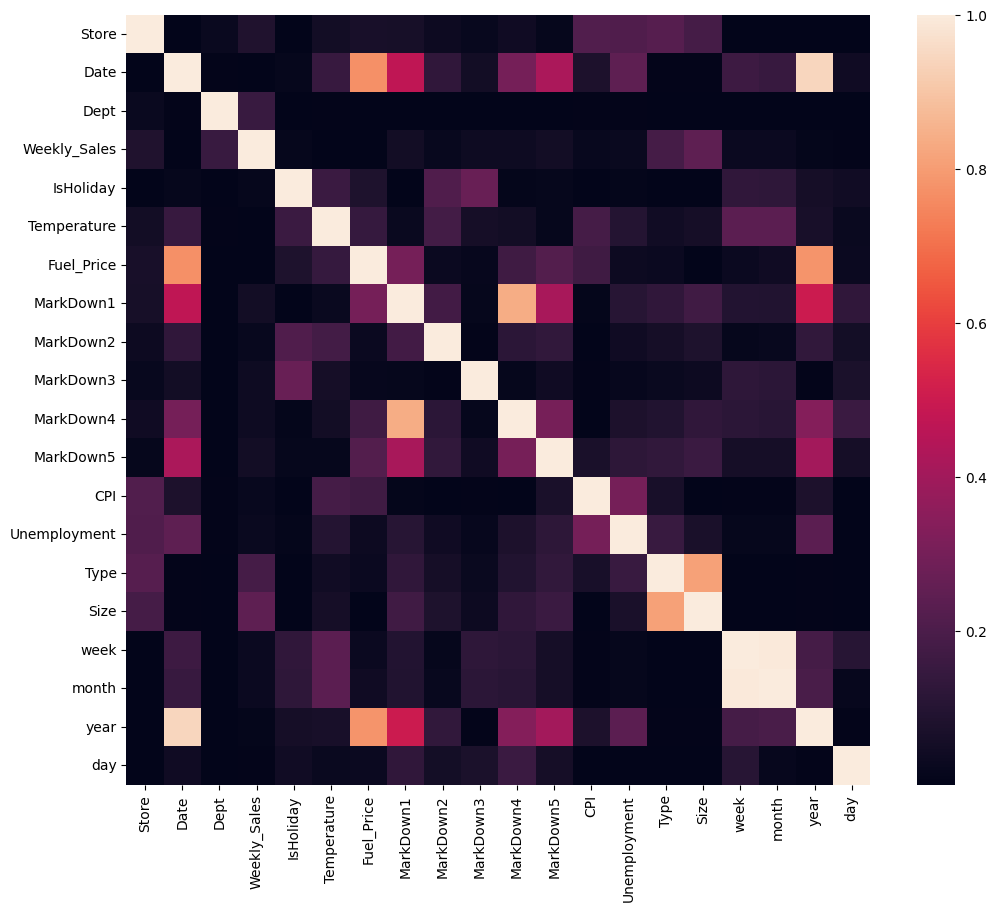

In [153]:
#Analysing the correlation between the features and 'Weekly_Sales':
import matplotlib.pyplot as plt #type:ignore 
import seaborn as sns #type:ignore

plt.figure(figsize=(12,10))
sns.heatmap(df.corr().abs())  # To see the correlations
plt.show()


from above correlation heat map, it is observed that , the features temperature, unemployment, CPI, Fuel_Price do not have any correlation to weeklysales so I will remove them as features to be considered, since MarkDown 4 and 5 are correlated to MarkDown 1 and 2, I'll remove  4 and 5 as well. 

In [154]:
drop_col = ['Temperature','CPI','Fuel_Price','Unemployment','MarkDown4','MarkDown5']
df.drop(drop_col, axis=1, inplace=True) # dropping columns

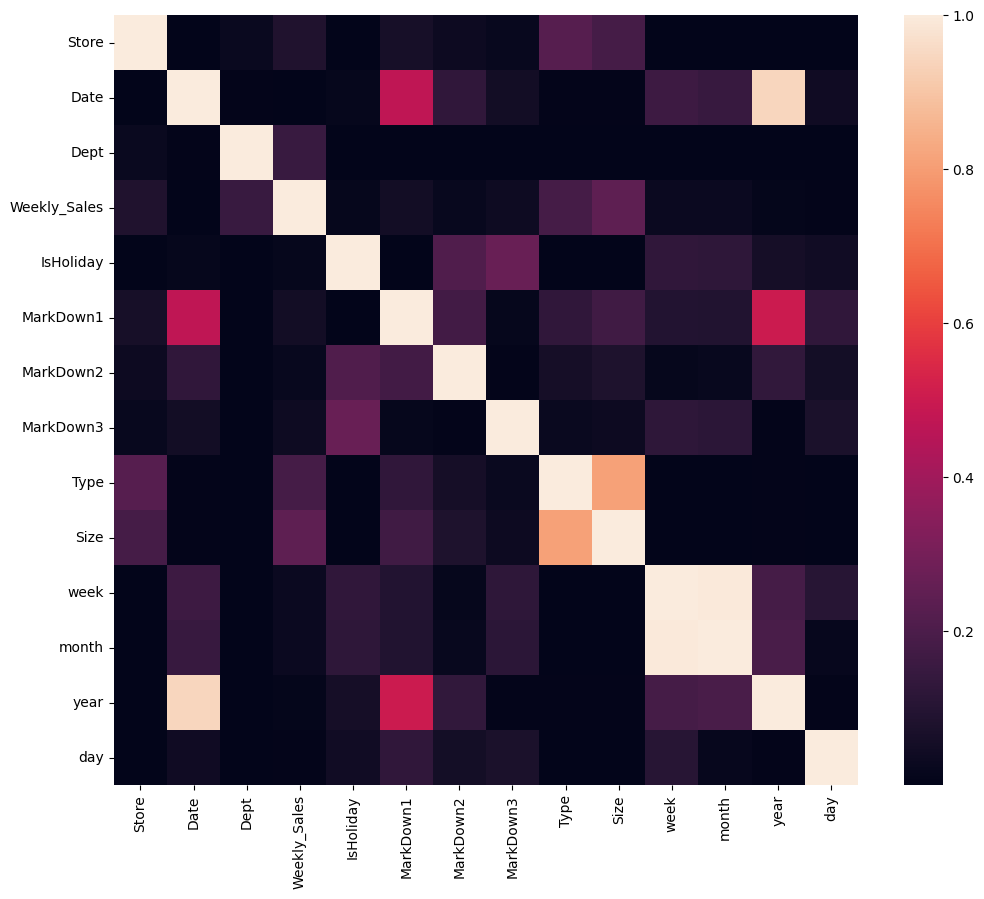

In [155]:
#Analysing the correlation between the features and 'Weekly_Sales' after dropping some features:

plt.figure(figsize=(12,10))
sns.heatmap(df.corr().abs())  # To see the correlations
plt.show()

In [156]:
#create test-train splits of data:
train_data = df[:int(0.7*(len(df)))]
test_data = df[int(0.7*(len(df))):]

target = "Weekly_Sales"
used_cols = [c for c in df.columns.to_list() if c not in [target]] # all columns except weekly sales

X_train = train_data[used_cols]
X_test = test_data[used_cols]
y_train = train_data[target]
y_test = test_data[target]

In [157]:
#Need to drop the Date column as the date type format is not supported for analysis and will throw an error:
X = df[used_cols] #keeping train and test values together

X_train = X_train.drop(['Date'], axis=1) # dropping date from train
X_test = X_test.drop(['Date'], axis=1) # dropping date from test

I'm going to use WMAE (Weighted Mean Average Error) as a metric to evaluate the model's prediction.

In [158]:
#defining a function for metric:
import numpy as np  # type: ignore

def wmae_test(test, pred): # WMAE for test 
    weights = X_test['IsHoliday'].apply(lambda is_holiday:5 if is_holiday else 1)
    error = np.sum(weights * np.abs(test - pred), axis=0) / np.sum(weights)
    return error


Random Forest Regressor:

In [159]:
#Import all the needed libraries and modules
import itertools
import statsmodels.api as sm # type: ignore
import statsmodels.tsa.api as smt # type: ignore
import statsmodels.formula.api as smf  # type: ignore

from sklearn.model_selection import train_test_split # type: ignore
from statsmodels.tsa.seasonal import seasonal_decompose as season # type: ignore
from sklearn.metrics import mean_squared_error, mean_absolute_error # type: ignore
from sklearn.metrics import accuracy_score, balanced_accuracy_score # type: ignore
from sklearn.model_selection import cross_val_score # type: ignore
from sklearn.pipeline import make_pipeline, Pipeline # type: ignore
from sklearn.ensemble import RandomForestRegressor # type: ignore
from sklearn import metrics # type: ignore
from sklearn.linear_model import LinearRegression  # type: ignore
from sklearn import preprocessing # type: ignore

from statsmodels.tsa.holtwinters import ExponentialSmoothing # type: ignore
from statsmodels.tsa.stattools import adfuller, acf, pacf # type: ignore
from statsmodels.tsa.arima_model import ARIMA # type: ignore

from pmdarima.utils import decomposed_plot # type: ignore
from pmdarima.arima import decompose # type: ignore
from pmdarima import auto_arima # type: ignore


import warnings
warnings.filterwarnings("ignore")

In [160]:
rf = RandomForestRegressor(n_estimators=50, random_state=42, n_jobs=-1, max_depth=35,
                           max_features = 'sqrt',min_samples_split = 10)

from sklearn.preprocessing import RobustScaler #type: ignore
scaler = RobustScaler()

#making pipe tp use scaler and regressor together
pipe = make_pipeline(scaler,rf)

pipe.fit(X_train, y_train)

# predictions on train set
y_pred = pipe.predict(X_train)

# predictions on test set
y_pred_test = pipe.predict(X_test)

In [161]:
#calculateing WMAE:
wmae_test(y_test, y_pred_test)

6681.095989088299

Time Series Model for forecasting:

In [162]:
time_series_dataset.head()

,Store,Date,Dept,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size,week,month,year,day
0,1,2010-02-05,1,24924.50,0,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.09636,8.106,1,151315,5,2,2010,5
1,1,2010-02-12,1,46039.49,1,38.51,2.548,0.0,0.0,0.0,0.0,0.0,211.24217,8.106,1,151315,6,2,2010,12
2,1,2010-02-19,1,41595.55,0,39.93,2.514,0.0,0.0,0.0,0.0,0.0,211.28914,8.106,1,151315,7,2,2010,19
3,1,2010-02-26,1,19403.54,0,46.63,2.561,0.0,0.0,0.0,0.0,0.0,211.31964,8.106,1,151315,8,2,2010,26
4,1,2010-03-05,1,21827.90,0,46.50,2.625,0.0,0.0,0.0,0.0,0.0,211.35014,8.106,1,151315,9,3,2010,5


In [164]:
time_series_dataset.set_index('Date', inplace=True) #seting date as index
time_series_dataset.head()

,Store,Dept,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size,week,month,year,day
Date,,,,,,,,,,,,,,,,,,,
2010-02-05,1,1,24924.50,0,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.09636,8.106,1,151315,5,2,2010,5
2010-02-12,1,1,46039.49,1,38.51,2.548,0.0,0.0,0.0,0.0,0.0,211.24217,8.106,1,151315,6,2,2010,12
2010-02-19,1,1,41595.55,0,39.93,2.514,0.0,0.0,0.0,0.0,0.0,211.28914,8.106,1,151315,7,2,2010,19
2010-02-26,1,1,19403.54,0,46.63,2.561,0.0,0.0,0.0,0.0,0.0,211.31964,8.106,1,151315,8,2,2010,26
2010-03-05,1,1,21827.90,0,46.50,2.625,0.0,0.0,0.0,0.0,0.0,211.35014,8.106,1,151315,9,3,2010,5


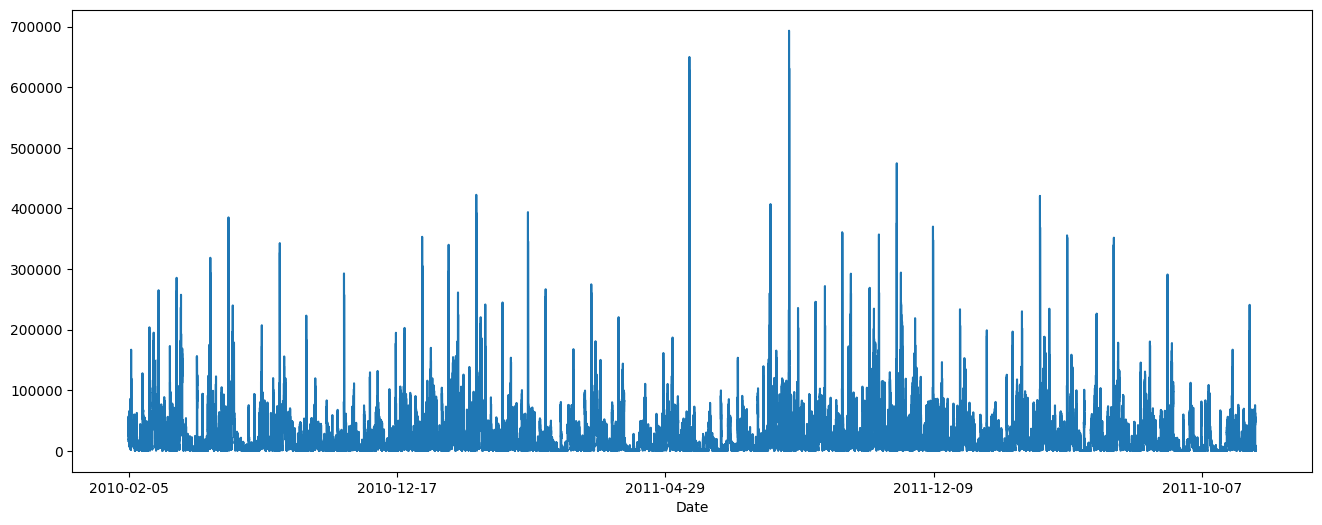

In [165]:
#visualize the sales on time:
plt.figure(figsize=(16,6))
dataset['Weekly_Sales'].plot()
plt.show()

In [173]:
#Resample the time_series_dataset with week , as ultimate goal is to forecast weekly sales in the end:
df_week = time_series_dataset.Weekly_Sales.resample('W').mean() #resample data as weekly

type(df_week)

pandas.core.series.Series

In [167]:
df_week.head()

Date
2010-02-07    16887.602176
2010-02-14    16390.912218
2010-02-21    16255.185970
2010-02-28    14955.932190
2010-03-07    15964.821243
Freq: W-SUN, Name: Weekly_Sales, dtype: float64

In [168]:
df_week2=pd.DataFrame([df_week])
df_week3 = df_week2.transpose() 
df_week3

,Weekly_Sales
Date,
2010-02-07,16887.602176
2010-02-14,16390.912218
2010-02-21,16255.185970
2010-02-28,14955.932190
2010-03-07,15964.821243
...,...
2012-09-30,14815.621121
2012-10-07,16037.442188
2012-10-14,15484.696200


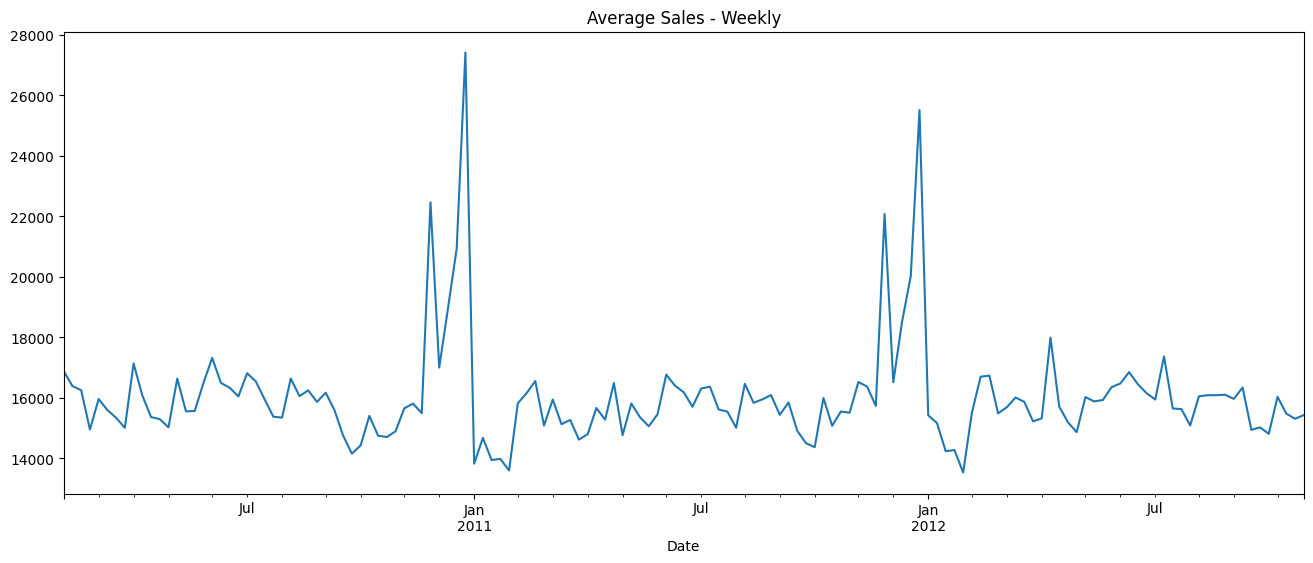

In [169]:
#Plot the average weekly sales:
plt.figure(figsize=(16,6))
df_week3['Weekly_Sales'].plot()
plt.title('Average Sales - Weekly')
plt.show()

Observe 2 weeks rolling mean and standard deviation:

In [170]:
roll_mean = df_week3['Weekly_Sales'].rolling(window=2, center=False).mean()
roll_std = df_week3['Weekly_Sales'].rolling(window=2, center=False).std()

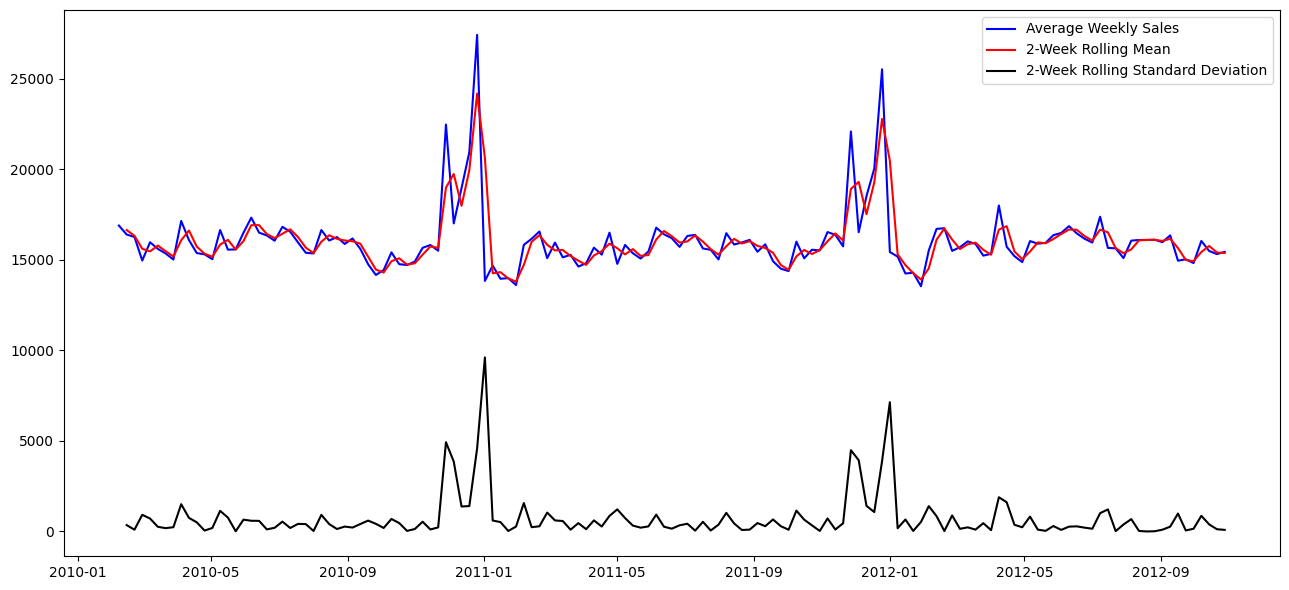

In [172]:
fig, ax = plt.subplots(figsize=(13, 6))
ax.plot(df_week3['Weekly_Sales'], color='blue',label='Average Weekly Sales')
ax.plot(roll_mean, color='red', label='2-Week Rolling Mean')
ax.plot(roll_std, color='black', label='2-Week Rolling Standard Deviation')
ax.legend()
fig.tight_layout()

From the above graph the data looks non-stationary due to the spikes at the end of a year. Therefore to analyse the series as whole I'll perform AD_fuller hypothesis test for stationarity of the series. 

In [174]:
adfuller(df_week3['Weekly_Sales'])

(-5.92710722656176,
 2.4290491728586084e-07,
 4,
 138,
 {'1%': -3.47864788917503,
  '5%': -2.882721765644168,
  '10%': -2.578065326612056},
 2261.5964210874386)

from the above test results with p-value << 0.05 , it provides strong indication that the series is overall stationary, eventhough the spikes observed. The spikes might affect the models performance ahead, therefore the series data needs to be preprocessed with Differencing, Shifting, Transformation.

In [175]:
#Split data for train and test for week_3:
train_data = df_week3[:int(0.7*(len(df_week3)))] 
test_data = df_week3[int(0.7*(len(df_week3))):]

print('Train:', train_data.shape)
print('Test:', test_data.shape)

Train: (100, 1)
Test: (43, 1)


In [176]:
target = "Weekly_Sales"
used_cols = [c for c in df_week3.columns.to_list() if c not in [target]] # all columns except price

# assigning train-test X-y values

X_train = train_data[used_cols]
X_test = test_data[used_cols]
y_train = train_data[target]
y_test = test_data[target]

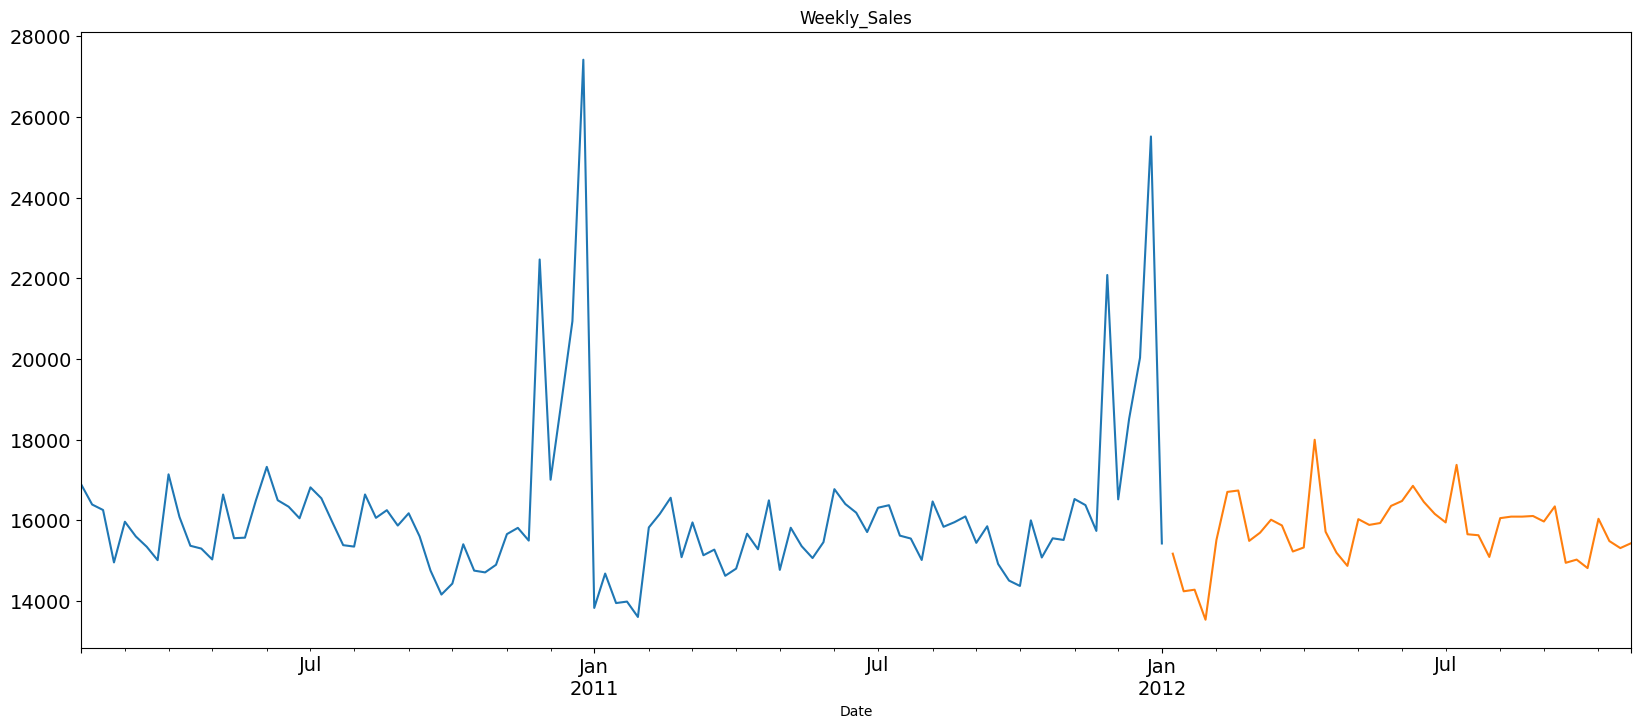

In [177]:
train_data['Weekly_Sales'].plot(figsize=(20,8), title= 'Weekly_Sales', fontsize=14)
test_data['Weekly_Sales'].plot(figsize=(20,8), title= 'Weekly_Sales', fontsize=14)
plt.show()

#Applying Auto-ARIMA

Decomposing the data to observe seasonality and trend:

In [178]:
decomposed = decompose(df_week3['Weekly_Sales'].values, 'additive', m=20) #decomposing of weekly data

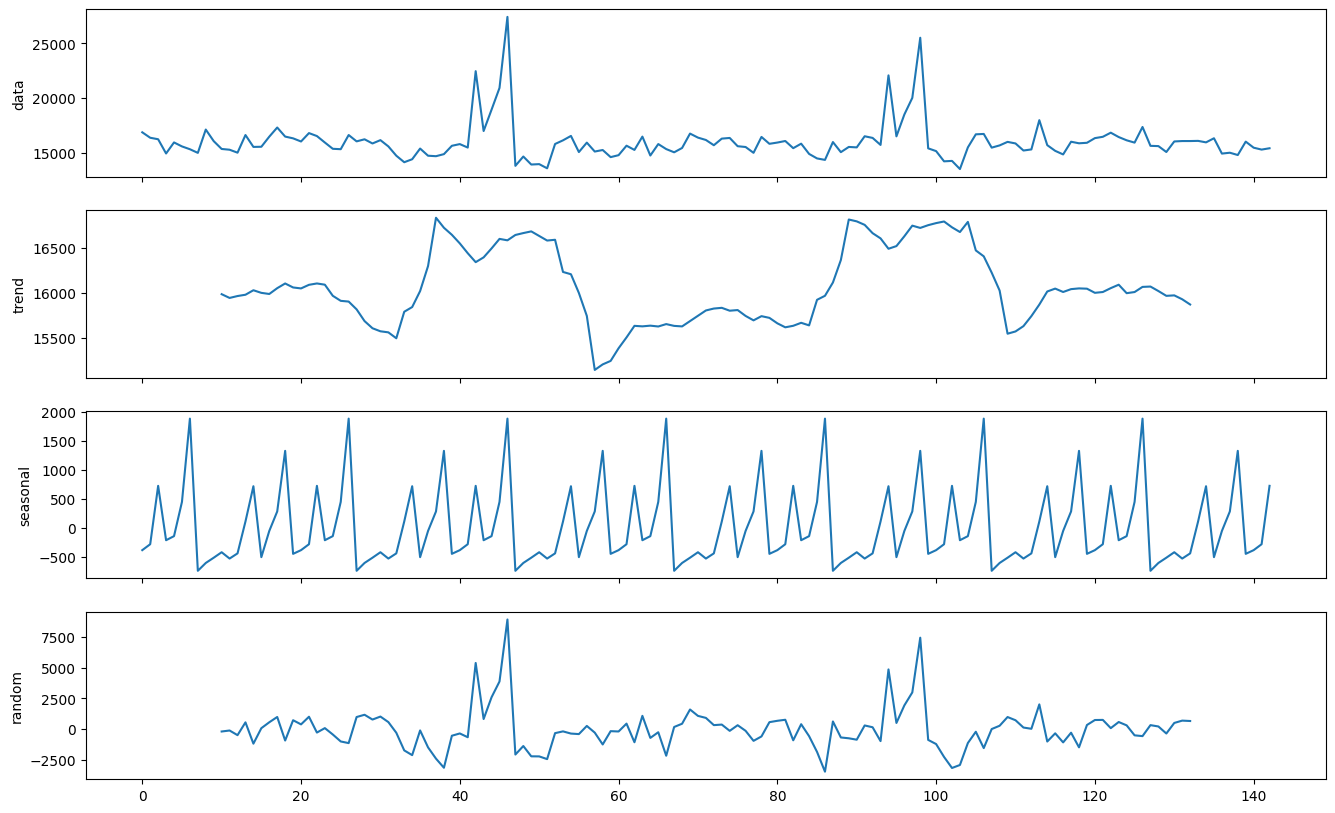

In [179]:
decomposed_plot(decomposed, figure_kwargs={'figsize': (16, 10)})
plt.show()

Making the data more stationary

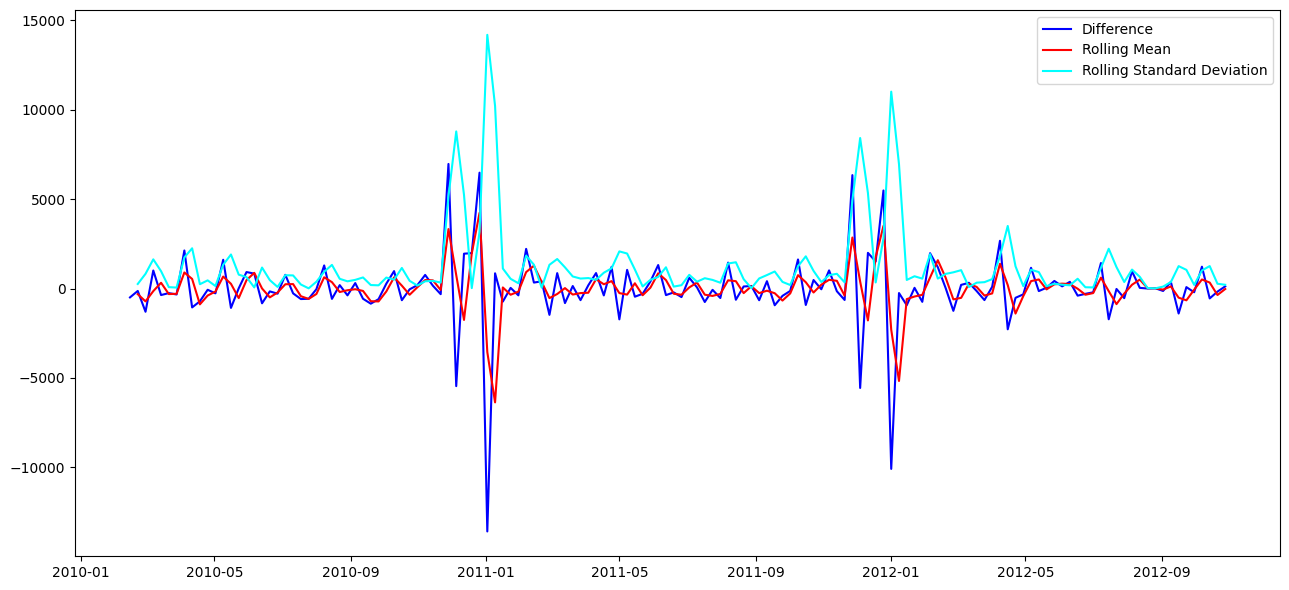

In [182]:
#using Difference method

df_week_diff = df_week3['Weekly_Sales'].diff().dropna() #creating difference values

# taking mean and std of differenced data
diff_roll_mean = df_week_diff.rolling(window=2, center=False).mean()
diff_roll_std = df_week_diff.rolling(window=2, center=False).std()

fig, ax = plt.subplots(figsize=(13, 6))
ax.plot(df_week_diff, color='blue',label='Difference')
ax.plot(diff_roll_mean, color='red', label='Rolling Mean')
ax.plot(diff_roll_std, color='cyan', label='Rolling Standard Deviation')
ax.legend()
fig.tight_layout()

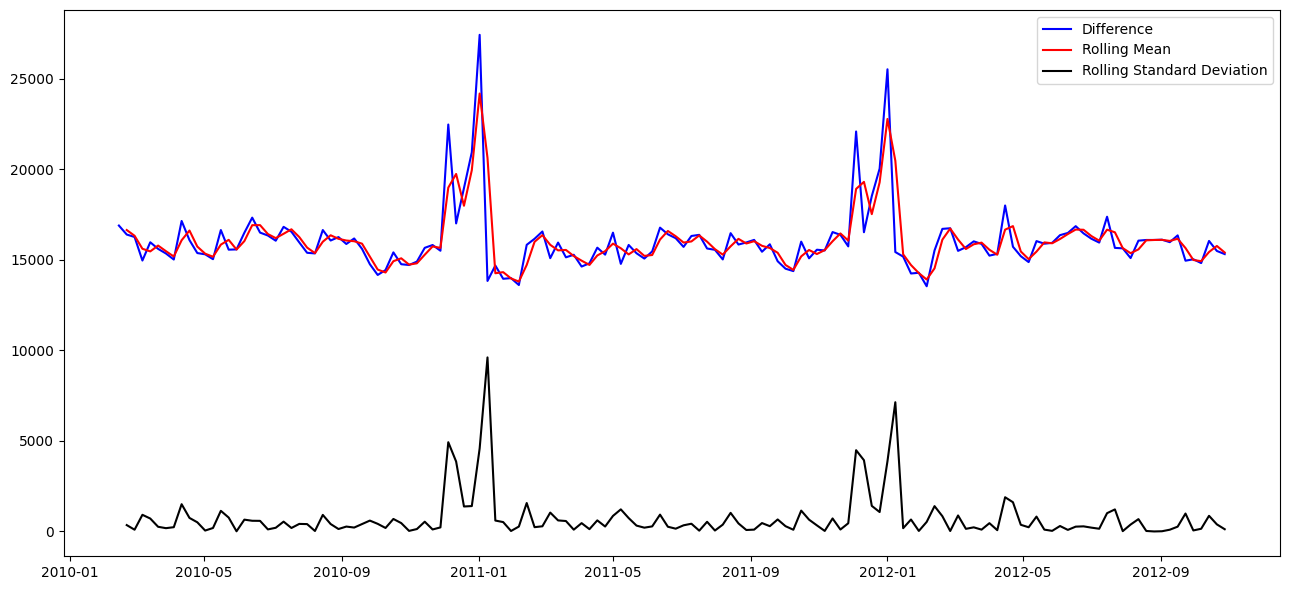

In [183]:
#Using Shifting method
df_week_lag = df_week3['Weekly_Sales'].shift().dropna() #shifting the data 

lag_roll_mean = df_week_lag.rolling(window=2, center=False).mean() 
lag_roll_std = df_week_lag.rolling(window=2, center=False).std()

fig, ax = plt.subplots(figsize=(13, 6))
ax.plot(df_week_lag, color='blue',label='Difference')
ax.plot(lag_roll_mean, color='red', label='Rolling Mean')
ax.plot(lag_roll_std, color='black', label='Rolling Standard Deviation')
ax.legend()
fig.tight_layout()

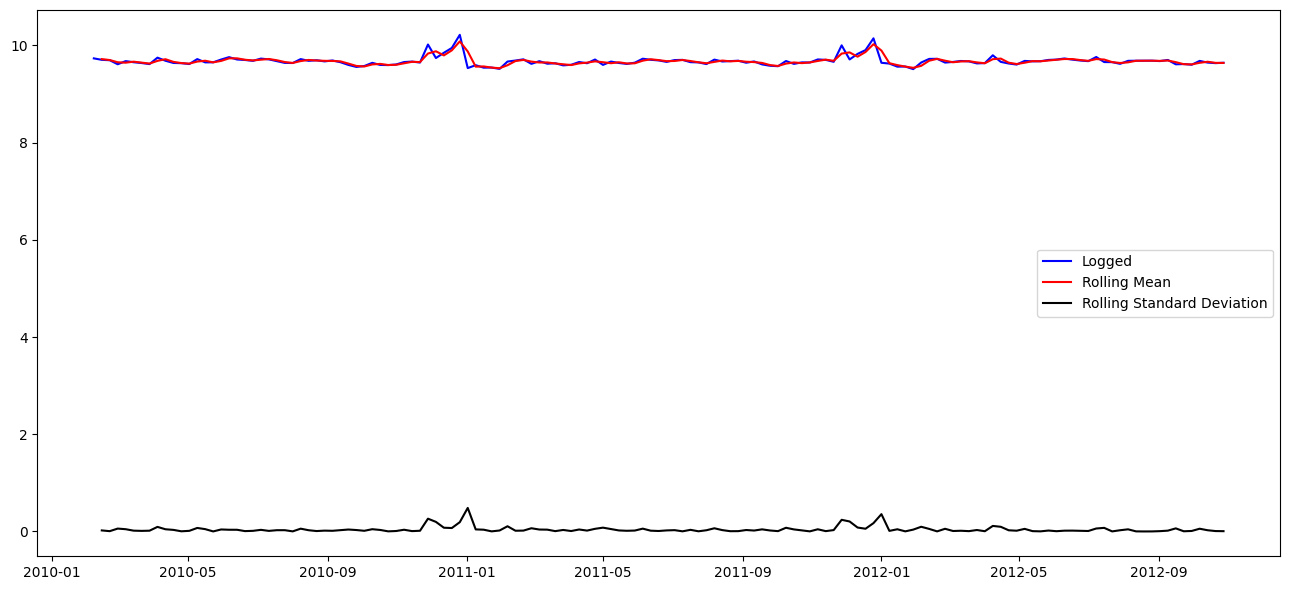

In [184]:
#using Log of data:
logged_week = np.log1p(df_week3['Weekly_Sales']).dropna() #taking log of data

log_roll_mean = logged_week.rolling(window=2, center=False).mean()
log_roll_std = logged_week.rolling(window=2, center=False).std()

fig, ax = plt.subplots(figsize=(13, 6))
ax.plot(logged_week, color='blue',label='Logged')
ax.plot(log_roll_mean, color='red', label='Rolling Mean')
ax.plot(log_roll_std, color='black', label='Rolling Standard Deviation')
ax.legend()
fig.tight_layout()

From the above preprocessing of the series, it is observed that the Differenced data gave best results in comparison to Log and Shifting. Therefore using it for Auto-ARIMA model for sales forecast.

In [185]:
train_data_diff = df_week_diff [:int(0.7*(len(df_week_diff )))]
test_data_diff = df_week_diff [int(0.7*(len(df_week_diff ))):]

In [186]:
model_auto_arima = auto_arima(train_data_diff, trace=True,start_p=0, start_q=0, start_P=0, start_Q=0,
                  max_p=20, max_q=20, max_P=20, max_Q=20, seasonal=True,maxiter=200,
                  information_criterion='aic',stepwise=False, suppress_warnings=True, D=1, max_D=10,
                  error_action='ignore',approximation = False)
model_auto_arima.fit(train_data_diff)

 ARIMA(0,0,0)(0,0,0)[1] intercept   : AIC=1826.858, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[1] intercept   : AIC=1793.619, Time=0.06 sec
 ARIMA(0,0,2)(0,0,0)[1] intercept   : AIC=1795.532, Time=0.14 sec
 ARIMA(0,0,3)(0,0,0)[1] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,0,4)(0,0,0)[1] intercept   : AIC=inf, Time=0.35 sec
 ARIMA(0,0,5)(0,0,0)[1] intercept   : AIC=inf, Time=0.21 sec
 ARIMA(1,0,0)(0,0,0)[1] intercept   : AIC=1804.051, Time=0.01 sec
 ARIMA(1,0,1)(0,0,0)[1] intercept   : AIC=inf, Time=0.19 sec
 ARIMA(1,0,2)(0,0,0)[1] intercept   : AIC=1794.966, Time=0.13 sec
 ARIMA(1,0,3)(0,0,0)[1] intercept   : AIC=inf, Time=0.24 sec
 ARIMA(1,0,4)(0,0,0)[1] intercept   : AIC=inf, Time=0.32 sec
 ARIMA(2,0,0)(0,0,0)[1] intercept   : AIC=1801.215, Time=0.02 sec
 ARIMA(2,0,1)(0,0,0)[1] intercept   : AIC=inf, Time=0.25 sec
 ARIMA(2,0,2)(0,0,0)[1] intercept   : AIC=inf, Time=0.22 sec
 ARIMA(2,0,3)(0,0,0)[1] intercept   : AIC=inf, Time=0.41 sec
 ARIMA(3,0,0)(0,0,0)[1] intercept   : AIC=1791.045, Tim

ARIMA(maxiter=200, order=(3, 0, 2), scoring_args={},
      seasonal_order=(0, 0, 0, 1), suppress_warnings=True)

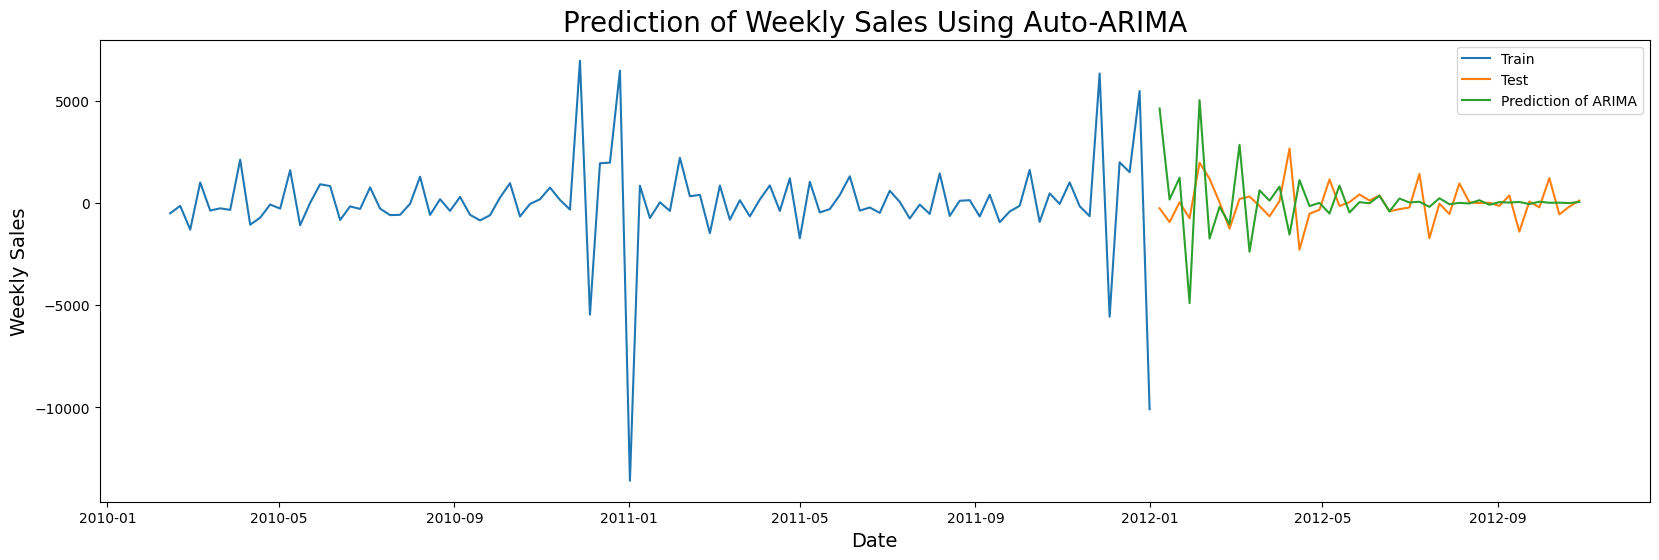

In [187]:
y_pred = model_auto_arima.predict(n_periods=len(test_data_diff))
y_pred = pd.DataFrame(y_pred,index = test_data.index,columns=['Prediction'])
plt.figure(figsize=(20,6))
plt.title('Prediction of Weekly Sales Using Auto-ARIMA', fontsize=20)
plt.plot(train_data_diff, label='Train')
plt.plot(test_data_diff, label='Test')
plt.plot(y_pred, label='Prediction of ARIMA')
plt.legend(loc='best')
plt.xlabel('Date', fontsize=14)
plt.ylabel('Weekly Sales', fontsize=14)
plt.show()

In [206]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Apply seasonal decomposition
df_week_seasonal = seasonal_decompose(df_week3['Weekly_Sales'], model='multiplicative', period=52) # Assuming weekly data with yearly seasonality

In [207]:
# Extract the residual component
residual = df_week_seasonal.resid.dropna()

# Split the residual component into training and test sets
split_idx = int(0.7 * len(residual))
train_residual = residual[:split_idx]
test_residual = residual[split_idx:]

In [208]:
# Fit the ARIMA model on the residual component
model_auto_arima = auto_arima(train_residual, trace=True, start_p=0, start_q=0, start_P=0, start_Q=0,
                              max_p=20, max_q=20, max_P=20, max_Q=20, seasonal=True, maxiter=200,
                              information_criterion='aic', stepwise=False, suppress_warnings=True, D=1, max_D=10,
                              error_action='ignore', approximation=False)
model_auto_arima.fit(train_residual)

 ARIMA(0,0,0)(0,0,0)[1] intercept   : AIC=-331.908, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[1] intercept   : AIC=-331.313, Time=0.11 sec
 ARIMA(0,0,2)(0,0,0)[1] intercept   : AIC=-329.315, Time=0.11 sec
 ARIMA(0,0,3)(0,0,0)[1] intercept   : AIC=-327.334, Time=0.24 sec
 ARIMA(0,0,4)(0,0,0)[1] intercept   : AIC=-325.802, Time=0.15 sec
 ARIMA(0,0,5)(0,0,0)[1] intercept   : AIC=-328.049, Time=0.31 sec
 ARIMA(1,0,0)(0,0,0)[1] intercept   : AIC=-331.289, Time=0.04 sec
 ARIMA(1,0,1)(0,0,0)[1] intercept   : AIC=-329.296, Time=0.08 sec
 ARIMA(1,0,2)(0,0,0)[1] intercept   : AIC=-327.313, Time=0.12 sec
 ARIMA(1,0,3)(0,0,0)[1] intercept   : AIC=-325.503, Time=0.26 sec
 ARIMA(1,0,4)(0,0,0)[1] intercept   : AIC=-325.125, Time=0.18 sec
 ARIMA(2,0,0)(0,0,0)[1] intercept   : AIC=-329.314, Time=0.03 sec
 ARIMA(2,0,1)(0,0,0)[1] intercept   : AIC=-327.310, Time=0.21 sec
 ARIMA(2,0,2)(0,0,0)[1] intercept   : AIC=-326.045, Time=0.27 sec
 ARIMA(2,0,3)(0,0,0)[1] intercept   : AIC=-323.367, Time=0.21 sec
 ARIMA(3,0

ARIMA(maxiter=200, order=(0, 0, 0), scoring_args={},
      seasonal_order=(0, 0, 0, 1), suppress_warnings=True)

In [209]:
# Print the model summary
print(model_auto_arima.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   63
Model:                        SARIMAX   Log Likelihood                 167.954
Date:                Sun, 14 Jul 2024   AIC                           -331.908
Time:                        11:58:42   BIC                           -327.621
Sample:                    08-08-2010   HQIC                          -330.222
                         - 10-16-2011                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.9970      0.002    463.714      0.000       0.993       1.001
sigma2         0.0003   3.24e-05      8.730      0.000       0.000       0.000
Ljung-Box (L1) (Q):                   1.45   Jarque-

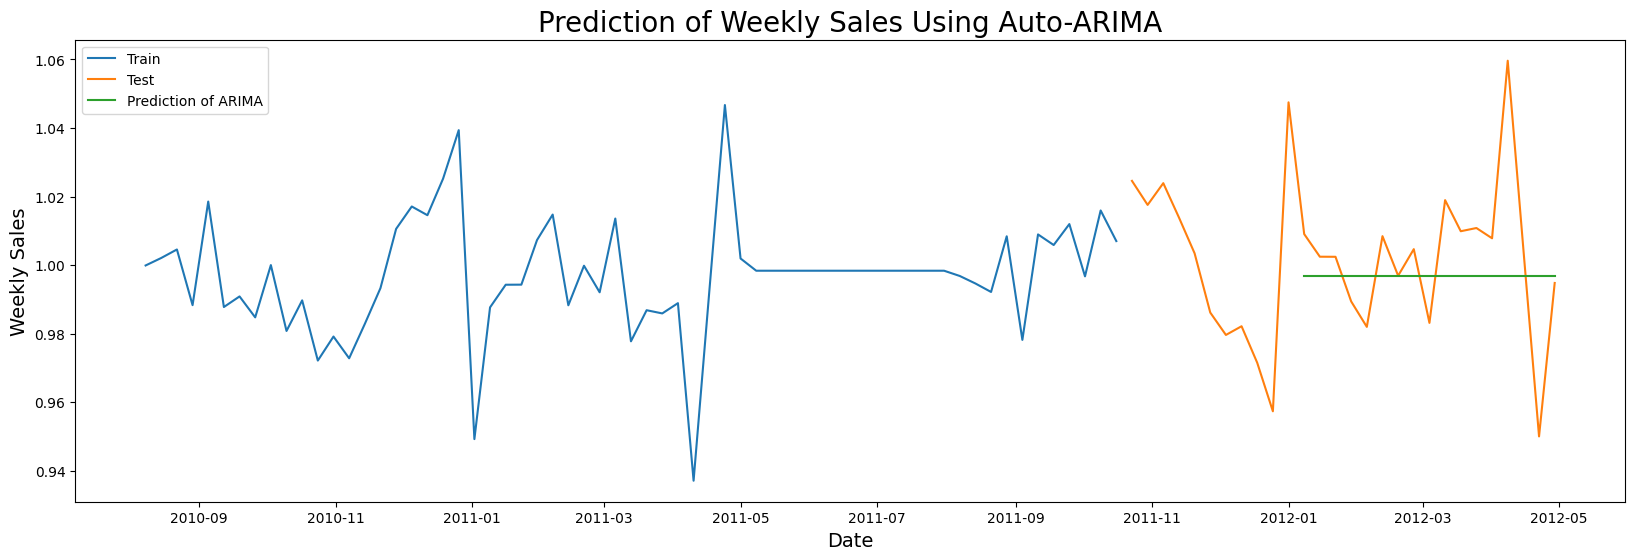

In [210]:
y_pred = model_auto_arima.predict(n_periods=len(test_residual))
y_pred = pd.DataFrame(y_pred,index = test_data.index,columns=['Prediction'])
plt.figure(figsize=(20,6))
plt.title('Prediction of Weekly Sales Using Auto-ARIMA', fontsize=20)
plt.plot(train_residual, label='Train')
plt.plot(test_residual, label='Test')
plt.plot(y_pred, label='Prediction of ARIMA')
plt.legend(loc='best')
plt.xlabel('Date', fontsize=14)
plt.ylabel('Weekly Sales', fontsize=14)
plt.show()

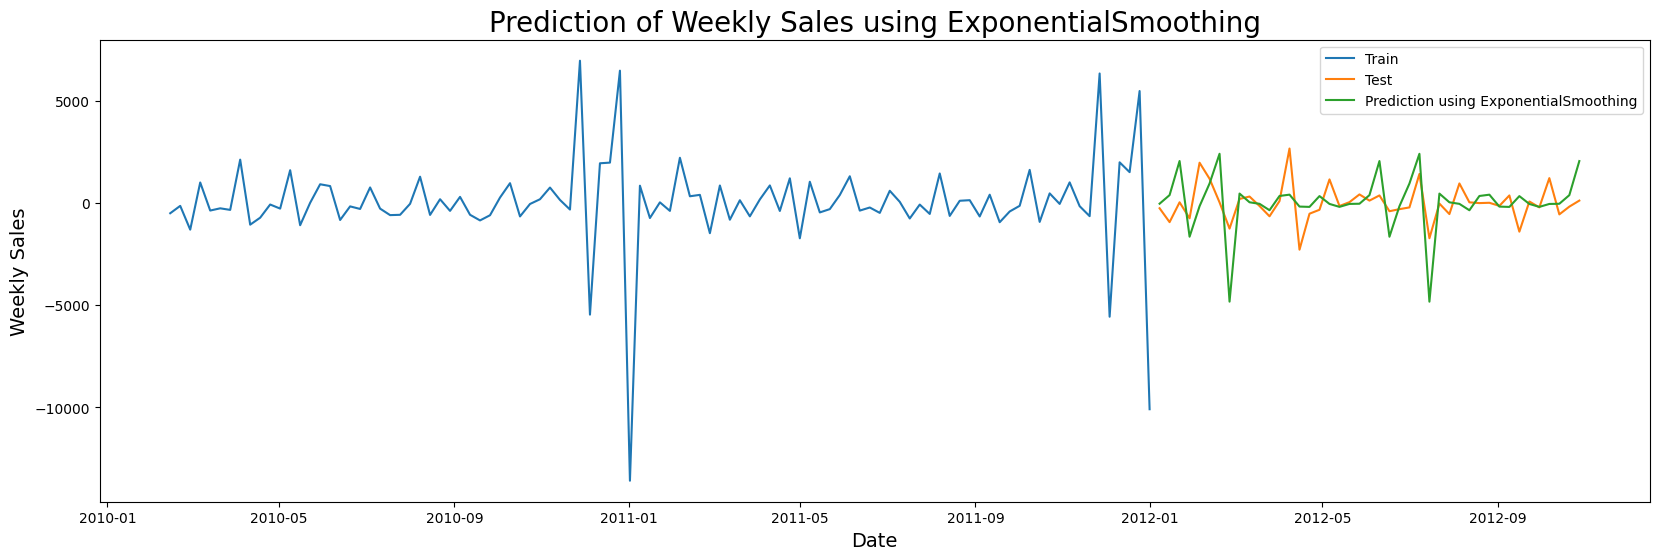

In [211]:
#Expoenential Smoothning:
model_holt_winters = ExponentialSmoothing(train_data_diff, seasonal_periods=20, seasonal='additive',
                                           trend='additive',damped=True).fit() #Taking additive trend and seasonality.
y_pred = model_holt_winters.forecast(len(test_data_diff))# Predict the test data

#Visualize train, test and predicted data.
plt.figure(figsize=(20,6))
plt.title('Prediction of Weekly Sales using ExponentialSmoothing', fontsize=20)
plt.plot(train_data_diff, label='Train')
plt.plot(test_data_diff, label='Test')
plt.plot(y_pred, label='Prediction using ExponentialSmoothing')
plt.legend(loc='best')
plt.xlabel('Date', fontsize=14)
plt.ylabel('Weekly Sales', fontsize=14)
plt.show()